In [2]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.8.0
The following GPU devices are available: /device:GPU:0


In [3]:
# Code to display image in a matplotlib frame
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [4]:
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg") #  Create a temporary file on disk to store the image.
  response = urlopen(url) 
  image_data = response.read()
  image_data = BytesIO(image_data) # Convert the response into an in-memory file
  pil_image = Image.open(image_data) # Convert the Image data to PIL internal data format using Image.Open
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # Resize the image to the standard required by the Machine learning algorithm
  pil_image_rgb = pil_image.convert("RGB") # Set the color recording format to RGB in contrast to CMYK or HSV
  pil_image_rgb.save(filename, format="JPEG", quality=90) # Save the Image to the file name given by tempfile.mkstemp
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [5]:
# Given an image and rectangle coordinates(and style), modify the image in-place.
# Also has logic to place the category classes on the rectangle such that it is 
# within the image and visible.
# This function is called multiple times by draw_boxes, one for each box present.
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  # xmin,xmax, ymin, ymax are float values between 0 & 1.
  # we multiply it with width, height of image to get the bounding box 
  # dimensions in pixels
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  
  # Draw the 4 lines as a polygon.
  # draw.line connects each point(pair of co-ordinates) to the next.
  # the 5th point is the first one to close the box
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # Calculate how tall the text is
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [6]:
# Given an image. the boxes which have detected objects, the corresponding names of the objects
# How confident the ML algo is on the classification for the corresponding boxes
# min_score is a cut-off point of confidence, below which not to draw the box
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values()) # just a bunch of pre-defined colors that we can use so that each category is marked a unique color

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  # Only display upto max_boxes number of boxes, as otherwise the screen will be messy
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      # This is the display text rendered on the bounding box
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      # pick a random color from the colors list such that, for a given category,
      # the same color is returned always(This is a property of Hashing algorithms)
      color = colors[hash(class_names[i]) % len(colors)]
      # Convert the image to a format that can be manipulated by PIL
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil)) # Over write the original image with the one that has the boxes
  return image

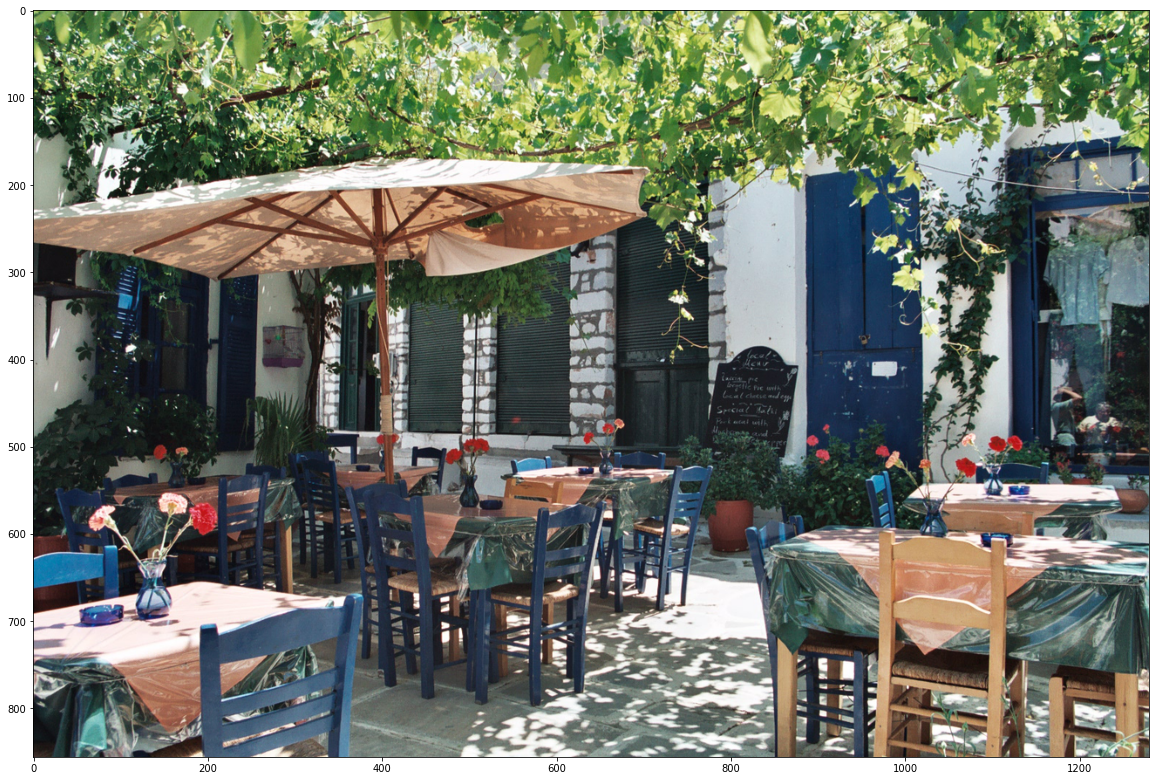

In [7]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [8]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3) # convert the image to a format that can be processed by Tensorflow
  return img

In [10]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...] # Conversion code, needed as this is running on GPU. And GPU is very very specific on what it wants
  start_time = time.time()
  result = detector(converted_img) # Run the detector and get the result with bounding boxes and classes.
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  #print("The objects are:", result["detection_class_entities"])
  print("Found %d objects." % len(result["detection_scores"])) # Ths
  #print("Inference time: ", end_time-start_time)
  
  list = result["detection_class_entities"].tolist()
  #print("list", list)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  if list.count(b'Tree')>5:
      if list.count(b'Plant')>5:
          if list.count(b'Animal')>5: 
              if list.count(b'Bird') > 5:
                  print("The environment is a forest")
  if list.count(b'Chair')>3:
      if list.count(b'Table')>3:
          if list.count(b'Houseplant')>3:
              print("You are sitting in a cafeteria")
          
  display_image(image_with_boxes)

In [11]:
run_detector(detector, downloaded_image_path)

Found 100 objects.
You are sitting in a cafeteria


In [12]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  #print(image_path)
  run_detector(detector, image_path)
  end_time = time.time()
  #print("Inference time:",end_time-start_time)

In [13]:
detect_img(image_urls[0])

Found 100 objects.


In [14]:
detect_img(image_urls[1])

Found 100 objects.


In [15]:
detect_img(image_urls[2])

Found 100 objects.
The environment is a forest
